# Home work 3: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **"multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- HW3_Modules.ipynb
- HW3_differentiation.ipynb

In [3]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

In [2]:
"""
    --------------------------------------
    -- Tech note
    --------------------------------------
    Inspired by torch I would use
    
    np.multiply, np.add, np.divide, np.subtract instead of *,+,/,-
    for better memory handling
        
    Suppose you allocated a variable    
        
        a = np.zeros(...)
    
    So, instead of
    
        a = b + c  # will be reallocated, GC needed to free
    
    I would go for: 
    
        np.add(b,c,out = a) # puts result in `a`
    
    But it is completely up to you.
"""
%run HW3_Modules.ipynb

Optimizer is implemented for you. 

In [6]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

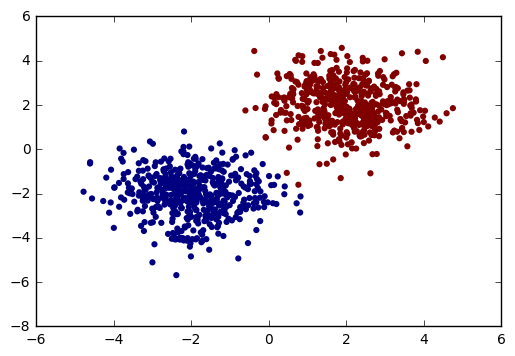

In [7]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [8]:
criterion = ClassNLLCriterion()
# criterion = MSECriterion()
net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(SoftMax())
print net

Linear 2 -> 4
ReLU
Linear 4 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [9]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [10]:
# batch generator
def get_batches( (X, Y) , batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

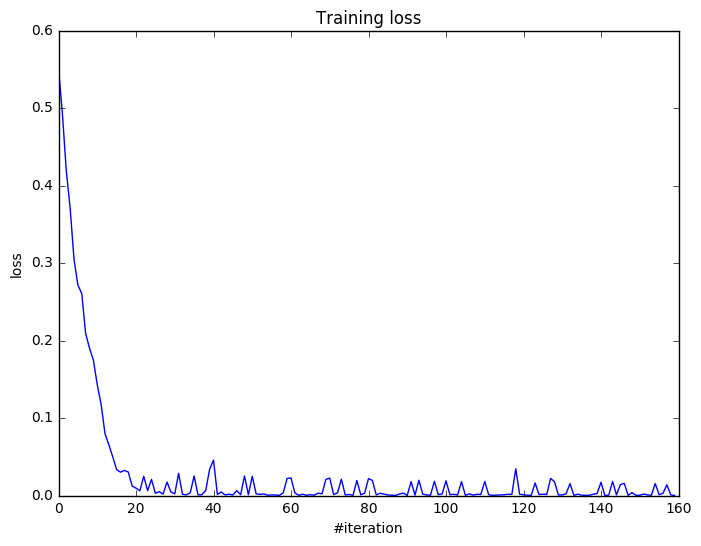

Current loss: 0.000074


In [11]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches( (X,Y) , batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [12]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

In [13]:
Y = np.zeros((y.shape[0], 10))
for i in range(y.shape[0]):
    Y[i][int(y[i])] = 1.

One-hot encode the labels first.

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchMeanSubtraction` between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchMeanSubtraction` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

In [14]:
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

n_epoch = 10
batch_size = 1000

In [15]:
criterion = ClassNLLCriterion()
#criterion = MSECriterion()

net = Sequential()
net.add(Linear(784, 100))
net.add(ReLU())
net.add(Linear(100, 10))
net.add(SoftMax())

loss_relu = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches( (X,Y) , batch_size):
        net.zeroGradParameters()        
        predictions = net.forward(x_batch)        
        loss = criterion.forward(predictions, y_batch)        
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        sgd_momentum(net.getParameters(), net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        loss_relu.append(loss)
    print('ReLU loss: %f' % loss)    


ReLU loss: 0.337319
ReLU loss: 0.243630
ReLU loss: 0.213375
ReLU loss: 0.173105
ReLU loss: 0.153863
ReLU loss: 0.110118
ReLU loss: 0.103732
ReLU loss: 0.108626
ReLU loss: 0.085138
ReLU loss: 0.087914


In [42]:
net = Sequential()
net.add(Linear(784, 100))
net.add(ELU(1.))
net.add(Linear(100, 10))
net.add(SoftMax())

loss_elu = []
for i in range(n_epoch):
    for x_batch, y_batch in get_batches( (X,Y) , batch_size):
        net.zeroGradParameters()
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        loss_elu.append(loss)
        
    print('ELU loss: %f' % loss)    

ELU loss: 0.360567
ELU loss: 0.305868
ELU loss: 0.215975
ELU loss: 0.205451
ELU loss: 0.211092
ELU loss: 0.172175
ELU loss: 0.135630
ELU loss: 0.107354
ELU loss: 0.102128
ELU loss: 0.112330


In [34]:
net = Sequential()
net.add(Linear(784, 100))
net.add(LeakyReLU(0.01))
net.add(Linear(100, 10))
net.add(SoftMax())

loss_leaky = []
for i in range(n_epoch):
    for x_batch, y_batch in get_batches( (X,Y) , batch_size):
        net.zeroGradParameters()
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        loss_leaky.append(loss)
        
    print('LeakyReLU loss: %f' % loss)

LeakyReLU loss: 0.315793
LeakyReLU loss: 0.283383
LeakyReLU loss: 0.174124
LeakyReLU loss: 0.142087
LeakyReLU loss: 0.167456
LeakyReLU loss: 0.108260
LeakyReLU loss: 0.119640
LeakyReLU loss: 0.100957
LeakyReLU loss: 0.086500
LeakyReLU loss: 0.083156


In [31]:
net = Sequential()
net.add(Linear(784, 100))
net.add(SoftPlus())
net.add(Linear(100, 10))
net.add(SoftMax())

loss_softplus = []
for i in range(n_epoch):
    for x_batch, y_batch in get_batches( (X,Y) , batch_size):
        net.zeroGradParameters()
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        loss_softplus.append(loss)
        
    print('SoftPlus loss: %f' % loss)    

SoftPlus loss: 0.348434
SoftPlus loss: 0.386504
SoftPlus loss: 0.304677
SoftPlus loss: 0.255457
SoftPlus loss: 0.210752
SoftPlus loss: 0.178864
SoftPlus loss: 0.146472
SoftPlus loss: 0.146366
SoftPlus loss: 0.141139
SoftPlus loss: 0.130984


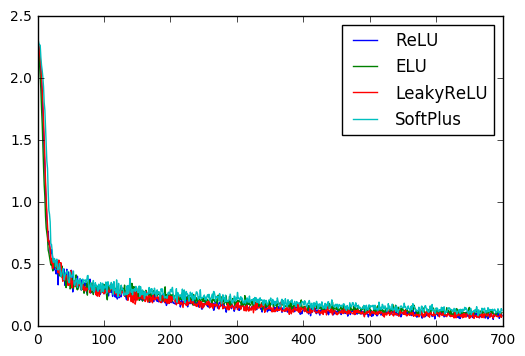

In [45]:
plt.plot(loss_relu)
plt.plot(loss_elu)
plt.plot(loss_leaky)
plt.plot(loss_softplus)
plt.legend(('ReLU', 'ELU', 'LeakyReLU', 'SoftPlus'))
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchMeanSubtraction` help?

** ReLu и LeakyReLU работают лучше всего, хуже работает SoftPlus, и это совпадает с мим представлением мира. Вообще на маленких сетках, наверное, между rely и leaky не должно замечаться большой разницы. Касательо времени вычисления, кажется, relu и leaky должны вычисляться быстрее, но по-факту все одинаково быстро. BatchMean спасает, опять же, на больших сетках. На маленьких не заметно особого улучшения. **

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. 

In [48]:
len(Y)

70000

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

In [53]:
from sklearn.metrics import accuracy_score

In [4]:
net = Sequential()
net.add(Linear(784, 100))
net.add(BatchMeanSubtraction())
net.add(LeakyReLU(0.01))
net.add(Linear(100, 10))
net.add(SoftMax())

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

n_epoch = 10
batch_size = 1000

loss_history_train, loss_history_val = [], []

In [68]:

for i in range(n_epoch):
    train_loss = 0
    train_acc = 0
    train_batches = 0
    for x_batch, y_batch in get_batches( (X_train,y_train) , batch_size):
        
        net.zeroGradParameters()
        
        predictions = net.forward(x_batch)
        train_loss += criterion.forward(predictions, y_batch)
#         print predictions.shape, y_batch.shape
#         print predictions[0], y_batch[0]
        y_pred = [np.argmax(predictions[i]) for i in range(len(predictions))]
        y_batch_test = [np.argmax(y_batch[i]) for i in range(len(y_batch))]
#         train_acc += np.mean(np.array([accuracy_score(predictions[i], y_batch[i]) for i in  range(len(predictions))]))
        train_acc += accuracy_score(y_pred, y_batch_test)
        train_batches += 1
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
#         loss_history_train.append(train_loss)
    val_loss = 0
    val_acc = 0
    val_batches = 0
    for x_batch, y_batch in get_batches( (X_test, y_test) , batch_size):
        predictions = net.forward(x_batch)
        val_loss += criterion.forward(predictions, y_batch)
        y_pred = [np.argmax(predictions[i]) for i in range(len(predictions))]
        y_batch_test = [np.argmax(y_batch[i]) for i in range(len(y_batch))]
        val_acc += accuracy_score(y_pred, y_batch_test)
        val_batches += 1
#         loss_history_val.append(val_loss)

#     display.clear_output(wait=True)
#     plt.figure(figsize=(8, 6))
        
#     plt.xlabel("#iteration")
#     plt.ylabel("loss")
#     plt.plot(loss_history_train)
#     plt.plot(loss_history_val)
#     plt.legend(('train', 'val'))
#     plt.show()
    
    print("training loss: {:.6f}, train accuracy: {:.3f}, validation accuracy: {:.3f}".format(train_loss / train_batches,\
        train_acc / train_batches * 100, val_acc / val_batches * 100))

training loss: 0.897286, train accuracy: 76.743, validation accuracy: 89.692
training loss: 0.323018, train accuracy: 90.618, validation accuracy: 91.542
training loss: 0.268914, train accuracy: 92.287, validation accuracy: 92.746
training loss: 0.227672, train accuracy: 93.456, validation accuracy: 93.425
training loss: 0.200324, train accuracy: 94.252, validation accuracy: 94.263
training loss: 0.175904, train accuracy: 94.934, validation accuracy: 94.667
training loss: 0.156941, train accuracy: 95.517, validation accuracy: 95.221
training loss: 0.141865, train accuracy: 95.925, validation accuracy: 95.537
training loss: 0.128804, train accuracy: 96.354, validation accuracy: 95.812
training loss: 0.118098, train accuracy: 96.644, validation accuracy: 96.167


Print here your accuracy. It should be around 90%.

In [72]:
y_pred = net.forward(X_test)
y_pred = [np.argmax(y_pred[i]) for i in range(len(y_pred))]
y_test_ = [np.argmax(y_test[i]) for i in range(len(y_test))]
print accuracy_score(y_pred, y_test_)

0.960952380952


# Autoencoder (optional) 

This part is **OPTIONAL**, you may not do it. It will not be scored, but it is easy and interesting.

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
<img src="autoencoder.png">

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use **MSECriterion** to score the reconstruction. Use **BatchMeanNormalization** between **Linear** and **ReLU**. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [ ]:
# Your code goes here. ################################################

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [ ]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################

# Now build a logistic regression or small classification net
cnet = Sequential()
cnet.add(Linear(30, 2))
cnet.add(SoftMax())

# Learn the weights
# Your code goes here. ################################################

# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
# Your code goes here. ################################################

# And add learned layers ontop.
autoenc.add(cnet[0])
autoenc.add(cnet[1])

# Now optimize whole model
# Your code goes here. ################################################

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [ ]:
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################